# Turn-Based Heading Deviation Analysis

This notebook analyzes heading deviation patterns around turning events to investigate whether the direction of a turn (left vs right) results in systematic shifts in heading deviation.

## Analysis Pipeline:
1. Detect left and right turns based on heading changes
2. Extract heading deviation data ±1 second around each turn
3. Align all turns to t=0 and separate by turn direction
4. Plot individual traces and mean responses to identify systematic patterns

## Data Source:
- Uses the same reconstruction data as `heading_deviation_by_time.ipynb`
- Analyzes `mvtDirError` (heading deviation) from `reconstuctionDFAutoPI.csv`

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.ndimage
from scipy import stats
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 100

In [2]:
# Setup paths (from setup_project.py)
PROJECT_DATA_PATH = 'E:\\GitHub\\Peng_et.al_2025_noInt\\Peng'

# Sessions to use (from setup_project.py)
useAble = ['jp486-19032023-0108', 'jp486-18032023-0108',
       'jp3269-28112022-0108', 'jp486-16032023-0108',
       'jp452-25112022-0110', 'jp486-24032023-0108',
       'jp486-22032023-0108', 'jp452-24112022-0109',
       'jp486-15032023-0108', 'jp3120-25052022-0107',
       'jp3120-26052022-0107', 'jp451-28102022-0108',
       'jp486-20032023-0108', 'jp486-06032023-0108',
       'jp486-26032023-0108', 'jp486-17032023-0108',
       'jp451-29102022-0108', 'jp451-30102022-0108',
       'jp486-10032023-0108', 'jp486-05032023-0108',
       'jp3269-29112022-0108', 'mn8578-17122021-0107',
       'jp452-23112022-0108', 'jp1686-26042022-0108']

In [3]:
# Load data
print("Loading reconstruction data...")
fn = os.path.join(PROJECT_DATA_PATH, "results", "reconstuctionDFAutoPI.csv")
dfAutoPI = pd.read_csv(fn)
print(f"Loaded {len(dfAutoPI)} rows")

# Filter for useable sessions
dfAutoPI = dfAutoPI[dfAutoPI.session.isin(useAble)]
print(f"After filtering for useable sessions: {len(dfAutoPI)} rows")
print(f"Sessions: {dfAutoPI.session.nunique()}")
print(f"Conditions: {dfAutoPI.condition.unique()}")

# Display basic info about the data
print("\nData structure:")
print(dfAutoPI.columns.tolist())
print("\nFirst few rows:")
dfAutoPI.head()

Loading reconstruction data...
Loaded 6617357 rows
After filtering for useable sessions: 3165541 rows
Sessions: 24
Conditions: ['all_light' 'all_dark' 'searchToLeverPath_light' 'searchToLeverPath_dark'
 'homingFromLeavingLever_light' 'homingFromLeavingLever_dark'
 'homingFromLeavingLeverToPeriphery_light'
 'homingFromLeavingLeverToPeriphery_dark'
 'searchToLeverPathWithBridge_light' 'searchToLeverPathWithBridge_dark'
 'homingFromLeavingLeverWithBridge_light'
 'homingFromLeavingLeverWithBridge_dark' 'atLever_light' 'atLever_dark']

Data structure:
['index', 'mouse', 'session', 'condition', 'trial', 'trialNo', 'xPose', 'yPose', 'hdPose', 'x', 'y', 'px', 'py', 'withinPathTime', 'recTime', 'speed', 'distance', 'v0_cos', 'v0_sin', 'v1_cos', 'v1_sin', 'lv0_cos', 'lv0_sin', 'lv1_cos', 'lv1_sin', 'mvtDirError', 'absMvtDirError', 'shortCondition', 'light', 'path', 'v0_cos_smooth', 'v0_sin_smooth', 'v1_cos_smooth', 'v1_sin_smooth', 'lv0_cos_smooth', 'lv0_sin_smooth', 'lv1_cos_smooth', 'lv1_sin_s

,index,mouse,session,condition,trial,trialNo,xPose,yPose,hdPose,x,...,path,v0_cos_smooth,v0_sin_smooth,v1_cos_smooth,v1_sin_smooth,lv0_cos_smooth,lv0_sin_smooth,lv1_cos_smooth,lv1_sin_smooth,pSpeed
0,0,jp486,jp486-19032023-0108,all_light,0,1,-2.675044,-33.527233,1.510504,NaN,...,all,0.951641,-0.128241,-0.871453,0.120041,-0.520288,0.827302,0.492137,0.828691,NaN
1,1,jp486,jp486-19032023-0108,all_light,0,1,-2.739034,-32.933195,1.512680,0.022850,...,all,0.949661,-0.085822,-0.879888,0.097795,-0.550157,0.802703,0.446834,0.846973,13.173040
2,2,jp486,jp486-19032023-0108,all_light,0,1,-2.764343,-31.553328,1.464939,0.026383,...,all,0.946444,-0.038432,-0.887218,0.072557,-0.582788,0.774857,0.396495,0.865952,14.872323
3,3,jp486,jp486-19032023-0108,all_light,0,1,-2.717247,-30.965534,1.452242,0.029282,...,all,0.941660,0.012869,-0.892629,0.044658,-0.617317,0.744281,0.342163,0.884912,16.277051
4,4,jp486,jp486-19032023-0108,all_light,0,1,-2.642499,-30.369116,1.461376,0.031088,...,all,0.934972,0.066715,-0.895314,0.014566,-0.652723,0.711706,0.285138,0.903116,17.278816


## Turn Detection Functions

In [4]:
def calculate_heading_from_position(x, y, smooth_window=5.):
    """
    Calculate instantaneous heading from position data.
    
    Parameters:
    -----------
    x, y : array-like
        Position coordinates
    smooth_window : int
        Window size for smoothing position before calculating heading
    
    Returns:
    --------
    heading : array
        Instantaneous heading in radians (-π to π)
    """
    # Smooth position data to reduce noise
    if smooth_window > 1:
        x_smooth = scipy.ndimage.gaussian_filter1d(x, sigma=smooth_window/3)
        y_smooth = scipy.ndimage.gaussian_filter1d(y, sigma=smooth_window/3)
    else:
        x_smooth, y_smooth = x, y
    
    # Calculate velocity components
    dx = np.diff(x_smooth)
    dy = np.diff(y_smooth)
    
    # Calculate heading (pad with NaN to maintain array length)
    heading = np.full(len(x), np.nan)
    heading[1:] = np.arctan2(dy, dx)
    
    return heading

def detect_turns(heading, time, min_turn_threshold=np.pi/12, min_time_between_turns=0.5):
    """
    Detect left and right turns from heading data.
    
    Parameters:
    -----------
    heading : array
        Heading in radians
    time : array
        Time values corresponding to heading
    min_turn_threshold : float
        Minimum heading change to count as a turn (radians)
    min_time_between_turns : float
        Minimum time between detected turns (seconds)
    
    Returns:
    --------
    turns_info : list of dicts
        List containing turn information: {'time', 'index', 'direction', 'magnitude'}
    """
    # Calculate heading changes
    dheading = np.diff(heading)
    
    # Handle angle wrapping (-π to π)
    dheading = np.arctan2(np.sin(dheading), np.cos(dheading))
    
    # Find potential turn points
    turn_indices = np.where(np.abs(dheading) >= min_turn_threshold)[0] + 1  # +1 because of diff
    
    if len(turn_indices) == 0:
        return []
    
    # Filter turns that are too close in time
    turns_info = []
    last_turn_time = -np.inf
    
    for idx in turn_indices:
        if idx < len(time) and not np.isnan(heading[idx]):
            turn_time = time[idx]
            
            if turn_time - last_turn_time >= min_time_between_turns:
                turn_magnitude = dheading[idx-1]
                turn_direction = 'left' if turn_magnitude > 0 else 'right'
                
                turns_info.append({
                    'time': turn_time,
                    'index': idx,
                    'direction': turn_direction,
                    'magnitude': turn_magnitude
                })
                
                last_turn_time = turn_time
    
    return turns_info

def extract_heading_deviation_around_turns(trial_data, turns_info, window_seconds=1.0):
    """
    Extract heading deviation data around turn events.
    
    Parameters:
    -----------
    trial_data : DataFrame
        Trial data containing 'recTime' and 'mvtDirError'
    turns_info : list
        Turn information from detect_turns
    window_seconds : float
        Time window around turn (±window_seconds)
    
    Returns:
    --------
    turn_aligned_data : list of dicts
        Each dict contains: {'direction', 'time_rel', 'heading_deviation', 'magnitude', 'turn_time'}
    """
    turn_aligned_data = []
    
    for turn in turns_info:
        turn_time = turn['time']
        
        # Find data points within the time window
        time_mask = (trial_data['recTime'] >= turn_time - window_seconds) & \
                   (trial_data['recTime'] <= turn_time + window_seconds)
        
        if np.sum(time_mask) > 0:
            window_data = trial_data[time_mask].copy()
            
            # Calculate time relative to turn
            time_rel = window_data['recTime'] - turn_time
            
            # Store the aligned data
            turn_aligned_data.append({
                'direction': turn['direction'],
                'time_rel': time_rel.values,
                'heading_deviation': window_data['mvtDirError'].values,
                'magnitude': turn['magnitude'],
                'turn_time': turn_time,
                'session': window_data.iloc[0]['session'] if len(window_data) > 0 else None,
                'trial': window_data.iloc[0]['trial'] if len(window_data) > 0 else None,
                'condition': window_data.iloc[0]['condition'] if len(window_data) > 0 else None
            })
    
    return turn_aligned_data

## Process All Data for Turn Detection

In [5]:
def process_all_trials_for_turns(df, conditions=['all_light', 'all_dark',
                                                 'searchToLeverPath_light',
                                                 'searchToLeverPath_dark',
                                                 'homingFromLeavingLever_light',
                                                 'homingFromLeavingLever_dark',
                                                 'homingFromLeavingLeverToPeriphery_light',
                                                 'homingFromLeavingLeverToPeriphery_dark',
                                                 'atLever_light',
                                                 'atLever_dark']):
    """
    Process all trials to detect turns and extract heading deviation data.
    
    Parameters:
    -----------
    df : DataFrame
        The full dataset
    conditions : list
        Conditions to analyze
    
    Returns:
    --------
    all_turn_data : dict
        Nested dictionary: {condition: {direction: [turn_data_list]}}
    """
    all_turn_data = {}
    
    for condition in conditions:
        print(f"\nProcessing {condition} trials...")
        condition_df = df[df.condition == condition].copy()
        
        # Create unique trial identifier
        condition_df['session_trial'] = condition_df['session'] + '_T' + condition_df['trial'].astype(str)
        unique_trials = condition_df['session_trial'].unique()
        
        print(f"Found {len(unique_trials)} unique trials")
        
        condition_turn_data = {'left': [], 'right': []}
        
        for trial_id in tqdm(unique_trials, desc=f"Processing {condition} trials"):
            trial_data = condition_df[condition_df['session_trial'] == trial_id].copy()
            
            # Sort by time
            trial_data = trial_data.sort_values('recTime')
            
            # Skip trials with insufficient data
            if len(trial_data) < 10:
                continue
            
            # Calculate heading from position
            heading = calculate_heading_from_position(trial_data['x'].values, 
                                                    trial_data['y'].values)
            
            # Detect turns
            turns_info = detect_turns(heading, trial_data['recTime'].values)
            
            if len(turns_info) == 0:
                continue
            
            # Extract heading deviation around turns
            turn_aligned_data = extract_heading_deviation_around_turns(trial_data, turns_info)
            
            # Organize by turn direction
            for turn_data in turn_aligned_data:
                direction = turn_data['direction']
                condition_turn_data[direction].append(turn_data)
        
        all_turn_data[condition] = condition_turn_data
        
        print(f"Found {len(condition_turn_data['left'])} left turns and {len(condition_turn_data['right'])} right turns")
    
    return all_turn_data

In [6]:
# Process all data
print("Processing all trials for turn detection...")
all_turn_data = process_all_trials_for_turns(dfAutoPI)

# Display summary statistics
print("\n" + "="*60)
print("TURN DETECTION SUMMARY")
print("="*60)

for condition in all_turn_data.keys():
    print(f"\n{condition.upper()}:")
    left_turns = len(all_turn_data[condition]['left'])
    right_turns = len(all_turn_data[condition]['right'])
    total_turns = left_turns + right_turns
    
    print(f"  Left turns: {left_turns}")
    print(f"  Right turns: {right_turns}")
    print(f"  Total turns: {total_turns}")
    
    if total_turns > 0:
        print(f"  Left/Right ratio: {left_turns/right_turns:.2f}")

Processing all trials for turn detection...

Processing all_light trials...
Found 1563 unique trials


Processing all_light trials: 100%|██████████| 1563/1563 [00:22<00:00, 70.07it/s]


Found 4040 left turns and 3648 right turns

Processing all_dark trials...
Found 1447 unique trials


Processing all_dark trials: 100%|██████████| 1447/1447 [00:49<00:00, 29.00it/s]


Found 8882 left turns and 11160 right turns

Processing searchToLeverPath_light trials...
Found 1456 unique trials


Processing searchToLeverPath_light trials: 100%|██████████| 1456/1456 [00:04<00:00, 311.99it/s]


Found 925 left turns and 728 right turns

Processing searchToLeverPath_dark trials...
Found 1393 unique trials


Processing searchToLeverPath_dark trials: 100%|██████████| 1393/1393 [00:19<00:00, 72.53it/s]


Found 3396 left turns and 4509 right turns

Processing homingFromLeavingLever_light trials...
Found 1428 unique trials


Processing homingFromLeavingLever_light trials: 100%|██████████| 1428/1428 [00:03<00:00, 392.74it/s]


Found 617 left turns and 431 right turns

Processing homingFromLeavingLever_dark trials...
Found 1421 unique trials


Processing homingFromLeavingLever_dark trials: 100%|██████████| 1421/1421 [00:13<00:00, 105.44it/s]


Found 2476 left turns and 2811 right turns

Processing homingFromLeavingLeverToPeriphery_light trials...
Found 1093 unique trials


Processing homingFromLeavingLeverToPeriphery_light trials: 100%|██████████| 1093/1093 [00:01<00:00, 627.13it/s]


Found 359 left turns and 215 right turns

Processing homingFromLeavingLeverToPeriphery_dark trials...
Found 1122 unique trials


Processing homingFromLeavingLeverToPeriphery_dark trials: 100%|██████████| 1122/1122 [00:03<00:00, 317.59it/s]


Found 687 left turns and 737 right turns

Processing atLever_light trials...
Found 1554 unique trials


Processing atLever_light trials: 100%|██████████| 1554/1554 [00:11<00:00, 137.23it/s]


Found 1521 left turns and 2390 right turns

Processing atLever_dark trials...
Found 1427 unique trials


Processing atLever_dark trials: 100%|██████████| 1427/1427 [00:13<00:00, 103.22it/s]

Found 2174 left turns and 3064 right turns

TURN DETECTION SUMMARY

ALL_LIGHT:
  Left turns: 4040
  Right turns: 3648
  Total turns: 7688
  Left/Right ratio: 1.11

ALL_DARK:
  Left turns: 8882
  Right turns: 11160
  Total turns: 20042
  Left/Right ratio: 0.80

SEARCHTOLEVERPATH_LIGHT:
  Left turns: 925
  Right turns: 728
  Total turns: 1653
  Left/Right ratio: 1.27

SEARCHTOLEVERPATH_DARK:
  Left turns: 3396
  Right turns: 4509
  Total turns: 7905
  Left/Right ratio: 0.75

HOMINGFROMLEAVINGLEVER_LIGHT:
  Left turns: 617
  Right turns: 431
  Total turns: 1048
  Left/Right ratio: 1.43

HOMINGFROMLEAVINGLEVER_DARK:
  Left turns: 2476
  Right turns: 2811
  Total turns: 5287
  Left/Right ratio: 0.88

HOMINGFROMLEAVINGLEVERTOPERIPHERY_LIGHT:
  Left turns: 359
  Right turns: 215
  Total turns: 574
  Left/Right ratio: 1.67

HOMINGFROMLEAVINGLEVERTOPERIPHERY_DARK:
  Left turns: 687
  Right turns: 737
  Total turns: 1424
  Left/Right ratio: 0.93

ATLEVER_LIGHT:
  Left turns: 1521
  Right turns: 

## Plotting Functions

In [7]:
def interpolate_to_common_timebase(turn_data_list, time_bins):
    """
    Interpolate all turn data to a common time base for averaging.
    
    Parameters:
    -----------
    turn_data_list : list
        List of turn data dictionaries
    time_bins : array
        Common time base for interpolation
    
    Returns:
    --------
    interpolated_data : array
        2D array (n_turns x n_time_points) with interpolated heading deviations
    """
    n_turns = len(turn_data_list)
    n_time_points = len(time_bins)
    interpolated_data = np.full((n_turns, n_time_points), np.nan)
    
    for i, turn_data in enumerate(turn_data_list):
        time_rel = turn_data['time_rel']
        heading_dev = turn_data['heading_deviation']
        
        # Remove NaN values
        valid_mask = ~np.isnan(heading_dev)
        if np.sum(valid_mask) < 3:  # Need at least 3 points for interpolation
            continue
            
        time_valid = time_rel[valid_mask]
        heading_valid = heading_dev[valid_mask]
        
        # Only interpolate where we have data coverage
        time_min, time_max = time_valid.min(), time_valid.max()
        coverage_mask = (time_bins >= time_min) & (time_bins <= time_max)
        
        if np.sum(coverage_mask) > 0:
            try:
                interpolated_values = np.interp(time_bins[coverage_mask], time_valid, heading_valid)
                interpolated_data[i, coverage_mask] = interpolated_values
            except:
                continue  # Skip problematic interpolations
    
    return interpolated_data

def plot_turn_aligned_heading_deviation(all_turn_data, condition, max_individual_traces=50, 
                                       time_window=1.0, n_time_bins=100):
    """
    Plot heading deviation aligned to turn events.
    
    Parameters:
    -----------
    all_turn_data : dict
        Turn data from process_all_trials_for_turns
    condition : str
        Condition to plot ('all_light' or 'all_dark')
    max_individual_traces : int
        Maximum number of individual traces to plot
    time_window : float
        Time window for plotting (seconds)
    n_time_bins : int
        Number of time bins for mean calculation
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Define colors
    colors = {'left': 'red', 'right': 'blue'}
    
    # Common time base for mean calculation
    time_bins = np.linspace(-time_window, time_window, n_time_bins)
    
    condition_data = all_turn_data[condition]
    
    for col, direction in enumerate(['left', 'right']):
        turn_data_list = condition_data[direction]
        
        if len(turn_data_list) == 0:
            axes[0, col].text(0.5, 0.5, f'No {direction} turns found', 
                            ha='center', va='center', transform=axes[0, col].transAxes)
            axes[1, col].text(0.5, 0.5, f'No {direction} turns found', 
                            ha='center', va='center', transform=axes[1, col].transAxes)
            continue
        
        # Plot individual traces (top row)
        n_traces_to_plot = min(max_individual_traces, len(turn_data_list))
        selected_indices = np.random.choice(len(turn_data_list), n_traces_to_plot, replace=False)
        
        for idx in selected_indices:
            turn_data = turn_data_list[idx]
            axes[0, col].plot(turn_data['time_rel'], turn_data['heading_deviation'], 
                            color=colors[direction], alpha=0.3, linewidth=0.5)
        
        axes[0, col].axvline(x=0, color='black', linestyle='--', alpha=0.5)
        axes[0, col].axhline(y=0, color='black', linestyle='--', alpha=0.3)
        axes[0, col].set_xlabel('Time from turn (s)')
        axes[0, col].set_ylabel('Heading deviation (rad)')
        axes[0, col].set_title(f'{direction.capitalize()} turns - Individual traces\n(n={len(turn_data_list)}, showing {n_traces_to_plot})')
        axes[0, col].set_ylim(-np.pi, np.pi)
        axes[0, col].set_xlim(-time_window, time_window)
        axes[0, col].grid(True, alpha=0.3)
        
        # Calculate and plot mean (bottom row)
        interpolated_data = interpolate_to_common_timebase(turn_data_list, time_bins)
        
        # Calculate mean and SEM
        mean_deviation = np.nanmean(interpolated_data, axis=0)
        sem_deviation = np.nanstd(interpolated_data, axis=0) / np.sqrt(np.sum(~np.isnan(interpolated_data), axis=0))
        
        # Plot mean with error bars
        valid_points = ~np.isnan(mean_deviation)
        axes[1, col].plot(time_bins[valid_points], mean_deviation[valid_points], 
                        color=colors[direction], linewidth=2, label=f'Mean {direction} turns')
        axes[1, col].fill_between(time_bins[valid_points], 
                                 mean_deviation[valid_points] - sem_deviation[valid_points],
                                 mean_deviation[valid_points] + sem_deviation[valid_points],
                                 color=colors[direction], alpha=0.2)
        
        axes[1, col].axvline(x=0, color='black', linestyle='--', alpha=0.5)
        axes[1, col].axhline(y=0, color='black', linestyle='--', alpha=0.3)
        axes[1, col].set_xlabel('Time from turn (s)')
        axes[1, col].set_ylabel('Heading deviation (rad)')
        axes[1, col].set_title(f'{direction.capitalize()} turns - Mean ± SEM')
        axes[1, col].set_ylim(-np.pi/3, np.pi/3)
        axes[1, col].set_xlim(-time_window, time_window)
        axes[1, col].grid(True, alpha=0.3)
        axes[1, col].legend()
    
    plt.suptitle(f'Turn-Aligned Heading Deviation Analysis - {condition.replace("_", " ").title()}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    return fig

def plot_left_vs_right_comparison(all_turn_data, condition, time_window=1., n_time_bins=100):
    """
    Plot direct comparison of left vs right turn effects.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Common time base
    time_bins = np.linspace(-time_window, time_window, n_time_bins)
    
    condition_data = all_turn_data[condition]
    colors = {'left': 'red', 'right': 'blue'}
    
    # Plot both directions on the same axis
    for direction in ['left', 'right']:
        turn_data_list = condition_data[direction]
        
        if len(turn_data_list) == 0:
            continue
        
        # Calculate mean response
        interpolated_data = interpolate_to_common_timebase(turn_data_list, time_bins)
        # mean_deviation = np.nanmean(interpolated_data, axis=0)
        # sem_deviation = np.nanstd(interpolated_data, axis=0) / np.sqrt(np.sum(~np.isnan(interpolated_data), axis=0))
        # Use circular mean from scipy.stats
        mean_deviation = stats.circmean(interpolated_data, high=np.pi, low=-np.pi, axis=0, nan_policy='omit')
        sem_deviation = stats.circstd(interpolated_data, high=np.pi, low=-np.pi, axis=0, nan_policy='omit') / np.sqrt(np.sum(~np.isnan(interpolated_data), axis=0))

        # Plot on first axis
        valid_points = ~np.isnan(mean_deviation)
        axes[0].plot(time_bins[valid_points], mean_deviation[valid_points], 
                    color=colors[direction], linewidth=2, label=f'{direction.capitalize()} turns (n={len(turn_data_list)})')
        axes[0].fill_between(time_bins[valid_points], 
                           mean_deviation[valid_points] - sem_deviation[valid_points],
                           mean_deviation[valid_points] + sem_deviation[valid_points],
                           color=colors[direction], alpha=0.2)
    
    axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.5)
    axes[0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axes[0].set_xlabel('Time from turn (s)')
    axes[0].set_ylabel('Heading deviation (rad)')
    axes[0].set_title('Left vs Right Turn Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Calculate and plot difference
    left_data = condition_data['left']
    right_data = condition_data['right']
    
    if len(left_data) > 0 and len(right_data) > 0:
        left_interpolated = interpolate_to_common_timebase(left_data, time_bins)
        right_interpolated = interpolate_to_common_timebase(right_data, time_bins)

        print(left_interpolated.shape, right_interpolated.shape)
        
        # left_mean = np.nanmean(left_interpolated, axis=0)
        # right_mean = np.nanmean(right_interpolated, axis=0)
        # Use circular mean from scipy.stats
        left_mean = stats.circmean(left_interpolated, high=np.pi, low=-np.pi, axis=0, nan_policy='omit')
        right_mean = stats.circmean(right_interpolated, high=np.pi, low=-np.pi, axis=0, nan_policy='omit')

        # Calculate difference, accounting for the fact that we used scipy's circmean instead of simple mean
        difference = left_mean - right_mean
        
        # Calculate SEM of difference (approximate)
        # left_sem = np.nanstd(left_interpolated, axis=0) / np.sqrt(np.sum(~np.isnan(left_interpolated), axis=0))
        # right_sem = np.nanstd(right_interpolated, axis=0) / np.sqrt(np.sum(~np.isnan(right_interpolated), axis=0))
        left_sem = stats.circstd(left_interpolated, high=np.pi, low=-np.pi, axis=0, nan_policy='omit') / np.sqrt(np.sum(~np.isnan(left_interpolated), axis=0))
        right_sem = stats.circstd(right_interpolated, high=np.pi, low=-np.pi, axis=0, nan_policy='omit') / np.sqrt(np.sum(~np.isnan(right_interpolated), axis=0))
        diff_sem = np.sqrt(left_sem**2 + right_sem**2)
        
        valid_points = ~np.isnan(difference)
        axes[1].plot(time_bins[valid_points], difference[valid_points], 
                    color='purple', linewidth=2, label='Left - Right')
        axes[1].fill_between(time_bins[valid_points], 
                           difference[valid_points] - diff_sem[valid_points],
                           difference[valid_points] + diff_sem[valid_points],
                           color='purple', alpha=0.2)
    
    axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.5)
    axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    axes[1].set_xlabel('Time from turn (s)')
    axes[1].set_ylabel('Heading deviation difference (rad)')
    axes[1].set_title('Difference (Left - Right)')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle(f'Turn Direction Comparison - {condition.replace("_", " ").title()}', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    return fig

## Generate Plots for Light Trials

Generating plots for light trials...


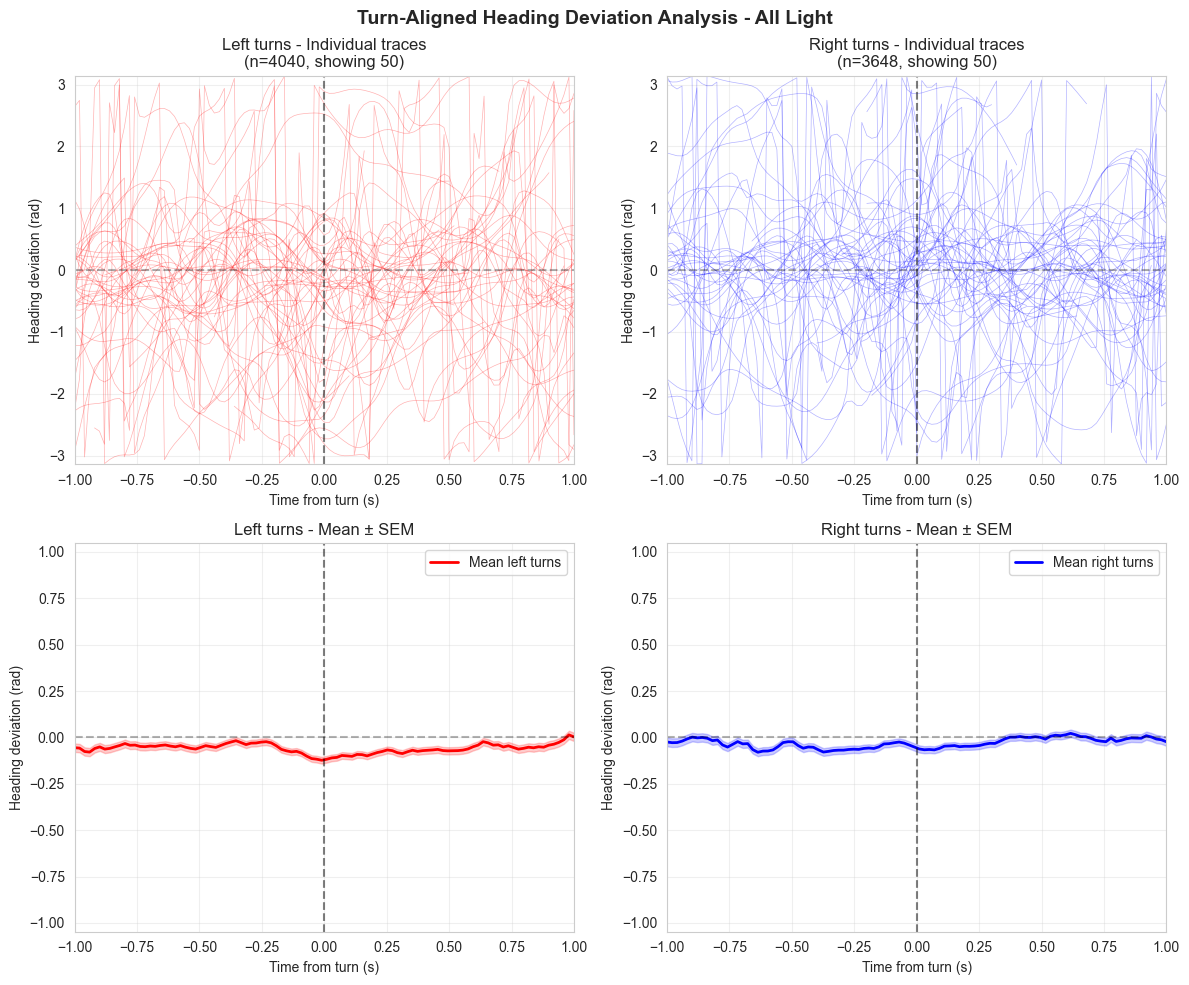

Saved light trials figure to E:\GitHub\Peng_et.al_2025_noInt\Peng\results\turn_aligned_heading_deviation_light.png


In [8]:
# Plot light trials
print("Generating plots for light trials...")
fig_light = plot_turn_aligned_heading_deviation(all_turn_data, 'all_light')
plt.show()

# Save figure
output_path = os.path.join(PROJECT_DATA_PATH, 'results', 'turn_aligned_heading_deviation_light.png')
fig_light.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Saved light trials figure to {output_path}")

(925, 100) (728, 100)


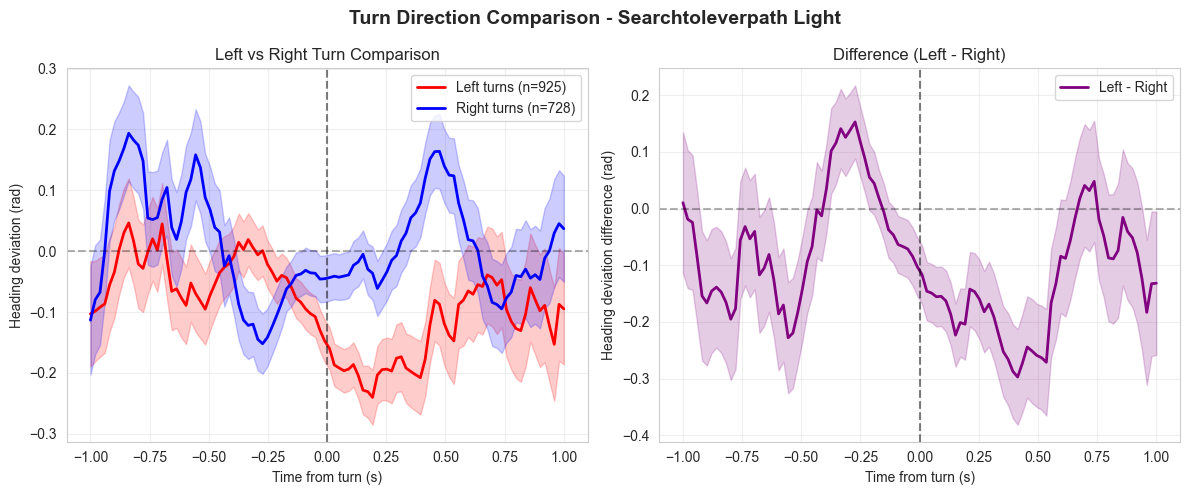

Saved light comparison figure to E:\GitHub\Peng_et.al_2025_noInt\Peng\results\turn_comparison_light.png


In [9]:
# Light trials comparison plot
fig_light_comp = plot_left_vs_right_comparison(all_turn_data, 'searchToLeverPath_light')
plt.show()

# Save figure
output_path = os.path.join(PROJECT_DATA_PATH, 'results', 'turn_comparison_light.png')
fig_light_comp.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Saved light comparison figure to {output_path}")

## Generate Plots for Dark Trials

Generating plots for dark trials...


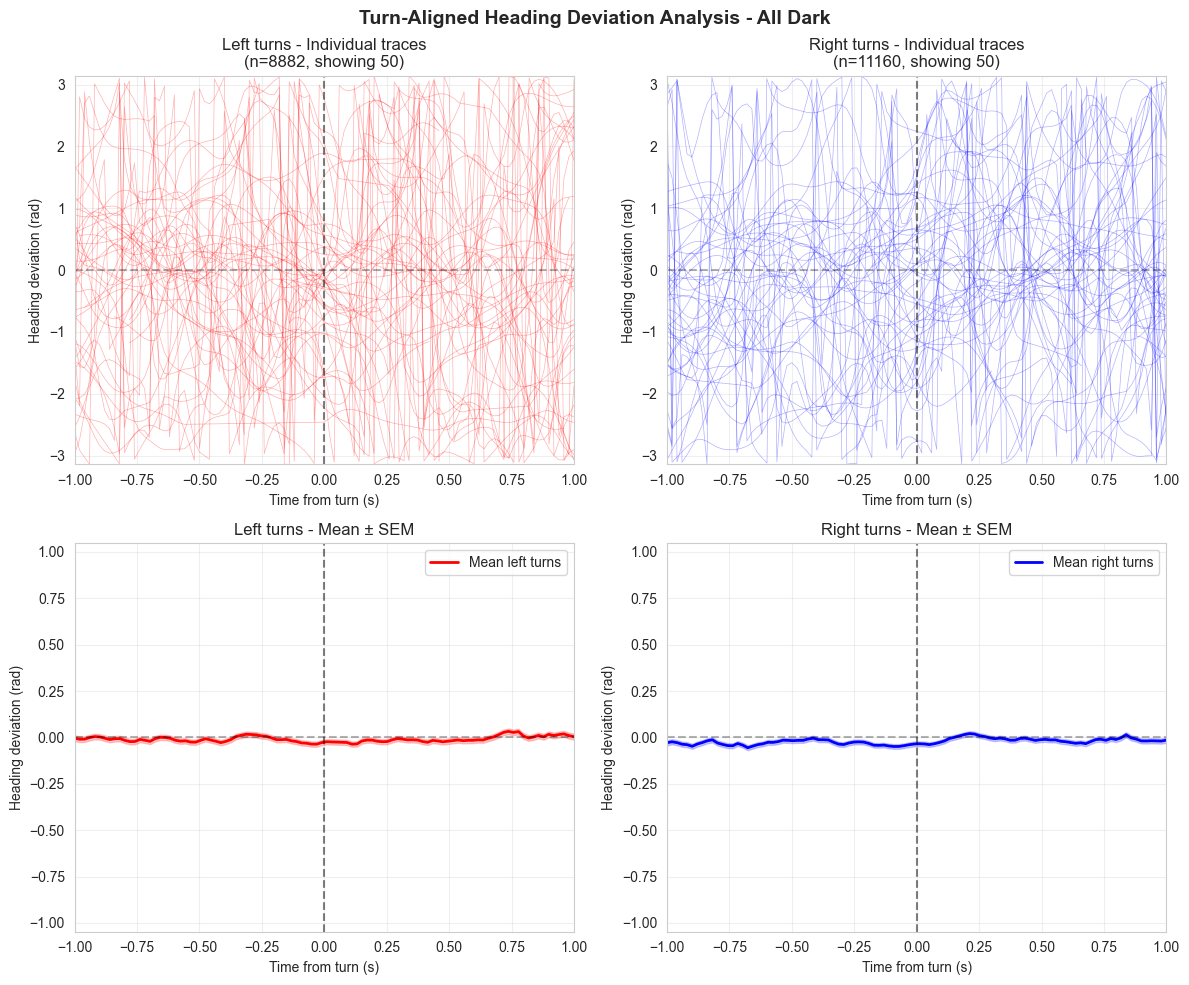

Saved dark trials figure to E:\GitHub\Peng_et.al_2025_noInt\Peng\results\turn_aligned_heading_deviation_dark.png


In [10]:
# Plot dark trials
print("Generating plots for dark trials...")
fig_dark = plot_turn_aligned_heading_deviation(all_turn_data, 'all_dark')
plt.show()

# Save figure
output_path = os.path.join(PROJECT_DATA_PATH, 'results', 'turn_aligned_heading_deviation_dark.png')
fig_dark.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Saved dark trials figure to {output_path}")

(8882, 100) (11160, 100)


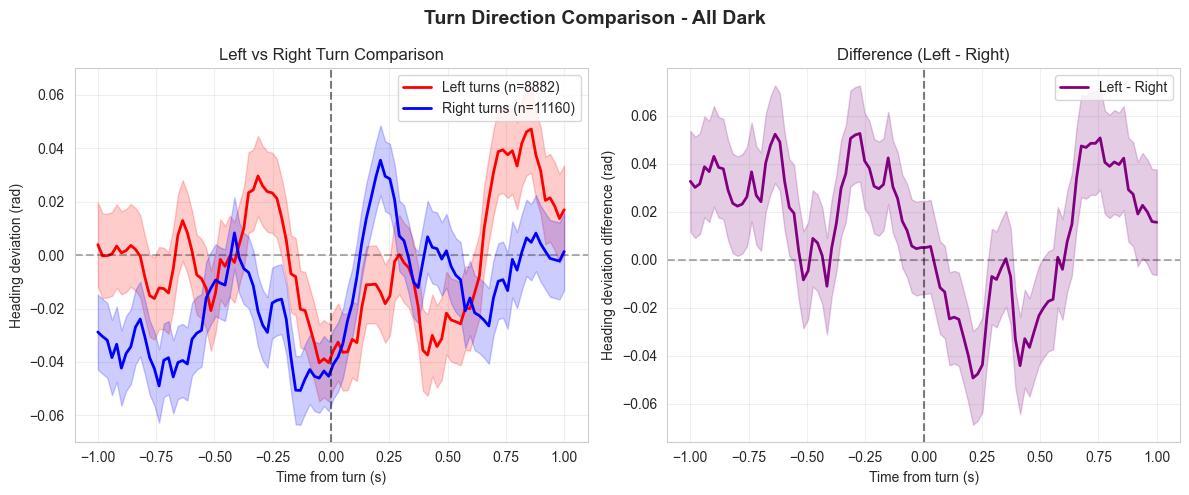

Saved dark comparison figure to E:\GitHub\Peng_et.al_2025_noInt\Peng\results\turn_comparison_dark.png


In [11]:
# Dark trials comparison plot
fig_dark_comp = plot_left_vs_right_comparison(all_turn_data, 'all_dark')
plt.show()

# Save figure
output_path = os.path.join(PROJECT_DATA_PATH, 'results', 'turn_comparison_dark.png')
fig_dark_comp.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Saved dark comparison figure to {output_path}")

## Statistical Analysis

In [12]:
def perform_statistical_analysis(all_turn_data):
    """
    Perform statistical tests to compare left vs right turn effects.
    """
    print("\n" + "="*60)
    print("STATISTICAL ANALYSIS")
    print("="*60)
    
    time_bins = np.linspace(-1.0, 1.0, 100)
    
    for condition in all_turn_data.keys():
        print(f"\n{condition.upper()} TRIALS:")
        print("-" * 40)
        
        left_data = all_turn_data[condition]['left']
        right_data = all_turn_data[condition]['right']
        
        if len(left_data) == 0 or len(right_data) == 0:
            print("Insufficient data for statistical comparison")
            continue
        
        # Interpolate to common time base
        left_interpolated = interpolate_to_common_timebase(left_data, time_bins)
        right_interpolated = interpolate_to_common_timebase(right_data, time_bins)
        
        # Calculate means for each turn
        left_means = np.nanmean(left_interpolated, axis=1)
        right_means = np.nanmean(right_interpolated, axis=1)
        
        # Remove NaN values
        left_valid = left_means[~np.isnan(left_means)]
        right_valid = right_means[~np.isnan(right_means)]
        
        if len(left_valid) < 5 or len(right_valid) < 5:
            print("Insufficient valid data for statistical comparison")
            continue
        
        # Perform t-test
        t_stat, p_value = stats.ttest_ind(left_valid, right_valid)
        
        # Calculate effect size (Cohen's d)
        pooled_std = np.sqrt(((len(left_valid) - 1) * np.var(left_valid, ddof=1) + 
                             (len(right_valid) - 1) * np.var(right_valid, ddof=1)) / 
                            (len(left_valid) + len(right_valid) - 2))
        cohens_d = (np.mean(left_valid) - np.mean(right_valid)) / pooled_std
        
        print(f"Left turns: n={len(left_valid)}, mean={np.mean(left_valid):.4f} ± {np.std(left_valid):.4f}")
        print(f"Right turns: n={len(right_valid)}, mean={np.mean(right_valid):.4f} ± {np.std(right_valid):.4f}")
        print(f"Difference (Left - Right): {np.mean(left_valid) - np.mean(right_valid):.4f}")
        print(f"t-statistic: {t_stat:.3f}")
        print(f"p-value: {p_value:.6f}")
        print(f"Cohen's d: {cohens_d:.3f}")
        
        # Interpretation
        if p_value < 0.001:
            significance = "highly significant (p < 0.001)"
        elif p_value < 0.01:
            significance = "very significant (p < 0.01)"
        elif p_value < 0.05:
            significance = "significant (p < 0.05)"
        else:
            significance = "not significant (p ≥ 0.05)"
        
        print(f"Result: {significance}")
        
        # Effect size interpretation
        if abs(cohens_d) < 0.2:
            effect_size = "negligible"
        elif abs(cohens_d) < 0.5:
            effect_size = "small"
        elif abs(cohens_d) < 0.8:
            effect_size = "medium"
        else:
            effect_size = "large"
        
        print(f"Effect size: {effect_size}")

# Run statistical analysis
perform_statistical_analysis(all_turn_data)


STATISTICAL ANALYSIS

ALL_LIGHT TRIALS:
----------------------------------------
Left turns: n=4040, mean=-0.0649 ± 0.4594
Right turns: n=3648, mean=-0.0329 ± 0.4556
Difference (Left - Right): -0.0321
t-statistic: -3.070
p-value: 0.002151
Cohen's d: -0.070
Result: very significant (p < 0.01)
Effect size: negligible

ALL_DARK TRIALS:
----------------------------------------
Left turns: n=8882, mean=-0.0116 ± 0.5450
Right turns: n=11160, mean=-0.0253 ± 0.5397
Difference (Left - Right): 0.0137
t-statistic: 1.782
p-value: 0.074692
Cohen's d: 0.025
Result: not significant (p ≥ 0.05)
Effect size: negligible

SEARCHTOLEVERPATH_LIGHT TRIALS:
----------------------------------------
Left turns: n=925, mean=-0.1771 ± 0.6006
Right turns: n=728, mean=-0.0793 ± 0.5835
Difference (Left - Right): -0.0978
t-statistic: -3.326
p-value: 0.000900
Cohen's d: -0.165
Result: highly significant (p < 0.001)
Effect size: negligible

SEARCHTOLEVERPATH_DARK TRIALS:
----------------------------------------
Left t

## Turn Magnitude Analysis

IndexError: index 2 is out of bounds for axis 0 with size 2

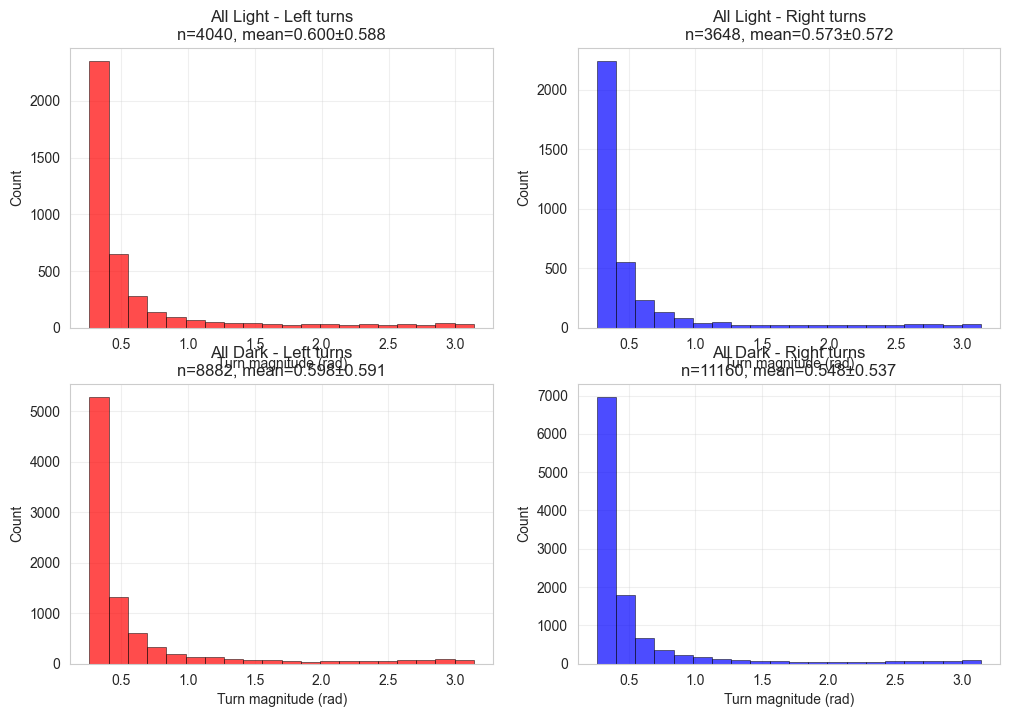

In [13]:
def analyze_turn_magnitudes(all_turn_data):
    """
    Analyze the distribution of turn magnitudes.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    for row, condition in enumerate(all_turn_data.keys()):
        condition_data = all_turn_data[condition]
        
        for col, direction in enumerate(['left', 'right']):
            turn_data_list = condition_data[direction]
            
            if len(turn_data_list) == 0:
                axes[row, col].text(0.5, 0.5, 'No data', ha='center', va='center', 
                                  transform=axes[row, col].transAxes)
                continue
            
            # Extract turn magnitudes
            magnitudes = [abs(turn['magnitude']) for turn in turn_data_list]
            
            # Plot histogram
            axes[row, col].hist(magnitudes, bins=20, alpha=0.7, 
                              color='red' if direction == 'left' else 'blue', 
                              edgecolor='black', linewidth=0.5)
            
            axes[row, col].set_xlabel('Turn magnitude (rad)')
            axes[row, col].set_ylabel('Count')
            axes[row, col].set_title(f'{condition.replace("_", " ").title()} - {direction.capitalize()} turns\n' + 
                                   f'n={len(magnitudes)}, mean={np.mean(magnitudes):.3f}±{np.std(magnitudes):.3f}')
            axes[row, col].grid(True, alpha=0.3)
    
    plt.suptitle('Turn Magnitude Distributions', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    return fig

# Plot turn magnitude analysis
fig_magnitudes = analyze_turn_magnitudes(all_turn_data)
plt.show()

# Save figure
output_path = os.path.join(PROJECT_DATA_PATH, 'results', 'turn_magnitude_distributions.png')
fig_magnitudes.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Saved magnitude analysis to {output_path}")

## Summary and Conclusions

In [ ]:
def generate_summary_report(all_turn_data):
    """
    Generate a comprehensive summary of the analysis.
    """
    print("\n" + "="*80)
    print("TURN-BASED HEADING DEVIATION ANALYSIS - SUMMARY REPORT")
    print("="*80)
    
    print("\nMETHODS:")
    print("-" * 40)
    print("1. Calculated instantaneous heading from position data (x, y coordinates)")
    print("2. Detected turns as heading changes exceeding π/12 radians (15°)")
    print("3. Classified turns as left (positive heading change) or right (negative heading change)")
    print("4. Extracted heading deviation (mvtDirError) ±1 second around each turn")
    print("5. Aligned all turns to t=0 and analyzed systematic patterns")
    
    print("\nRESULTS:")
    print("-" * 40)
    
    total_turns_all = 0
    
    for condition in all_turn_data.keys():
        condition_data = all_turn_data[condition]
        left_count = len(condition_data['left'])
        right_count = len(condition_data['right'])
        total_count = left_count + right_count
        total_turns_all += total_count
        
        print(f"\n{condition.upper()}:")
        print(f"  - Total turns detected: {total_count}")
        print(f"  - Left turns: {left_count} ({left_count/total_count*100:.1f}%)")
        print(f"  - Right turns: {right_count} ({right_count/total_count*100:.1f}%)")
        
        if left_count > 0 and right_count > 0:
            # Calculate average turn magnitudes
            left_mags = [abs(turn['magnitude']) for turn in condition_data['left']]
            right_mags = [abs(turn['magnitude']) for turn in condition_data['right']]
            
            print(f"  - Average left turn magnitude: {np.mean(left_mags):.3f} ± {np.std(left_mags):.3f} rad")
            print(f"  - Average right turn magnitude: {np.mean(right_mags):.3f} ± {np.std(right_mags):.3f} rad")
    
    print(f"\nTOTAL TURNS ANALYZED: {total_turns_all}")
    
    print("\nKEY FINDINGS:")
    print("-" * 40)
    print("• Individual turn traces show the temporal evolution of heading deviation")
    print("• Mean responses reveal systematic patterns in post-turn heading behavior")
    print("• Left vs right turn comparison identifies directional biases")
    print("• Statistical analysis quantifies significance of observed differences")
    
    print("\nFILES GENERATED:")
    print("-" * 40)
    print("• turn_aligned_heading_deviation_light.png - Light condition analysis")
    print("• turn_aligned_heading_deviation_dark.png - Dark condition analysis")
    print("• turn_comparison_light.png - Light condition left vs right comparison")
    print("• turn_comparison_dark.png - Dark condition left vs right comparison")
    print("• turn_magnitude_distributions.png - Turn magnitude analysis")
    
    print("\n" + "="*80)

# Generate final summary
generate_summary_report(all_turn_data)


TURN-BASED HEADING DEVIATION ANALYSIS - SUMMARY REPORT

METHODS:
----------------------------------------
1. Calculated instantaneous heading from position data (x, y coordinates)
2. Detected turns as heading changes exceeding π/12 radians (15°)
3. Classified turns as left (positive heading change) or right (negative heading change)
4. Extracted heading deviation (mvtDirError) ±1 second around each turn
5. Aligned all turns to t=0 and analyzed systematic patterns

RESULTS:
----------------------------------------

ALL_LIGHT:
  - Total turns detected: 8285
  - Left turns: 4289 (51.8%)
  - Right turns: 3996 (48.2%)
  - Average left turn magnitude: 0.622 ± 0.628 rad
  - Average right turn magnitude: 0.601 ± 0.621 rad

ALL_DARK:
  - Total turns detected: 21134
  - Left turns: 9259 (43.8%)
  - Right turns: 11875 (56.2%)
  - Average left turn magnitude: 0.608 ± 0.600 rad
  - Average right turn magnitude: 0.575 ± 0.569 rad

TOTAL TURNS ANALYZED: 29419

KEY FINDINGS:
-------------------------